In [4]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
import typing as tp

from PIL import Image

In [5]:
IMAGES_PATH = "./images"

def get_image(addr: str) -> Image:
    return Image.open(os.path.join(IMAGES_PATH, addr))

In [8]:
# get_image("2.jpg")

Для улучшения работы алгоритма применим гауссовское размытие с ядром 3x3 и получим градиенты с помощью оператора Собеля (итоговые градиенты --- с помощью операторов Собеля по двум осям в cv2).

In [41]:
def preprocess(img: Image, flip: bool = False) -> np.ndarray:
    """
    Required images preprocessing. Denoises images
    and applies Sobel filter.
    
    Cuts image width to a power of two to make 
    preprocessing easier. 
    
    TODO: resize image to greater size to find all
    lines on input image.
    
    Parameters:
    ----------
    img: PIL.Image
        image to transform
    flip: bool (default: False)
        flip image before processing or not
    
    Returns:
    grad: np.ndarray
        numpy representation of image
    """
    img = np.array(img)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    
    _, W, _= img.shape
    W = 2 ** int(np.log2(W))
    
    im_cropped = img[:, :W, :]
    if flip:
        im_cropped = np.flip(im_cropped, axis=1)
    
    g = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2GRAY)
    dx = cv2.Sobel(g, 3, 1, 0, ksize=3)
    dy = cv2.Sobel(g, 3, 0, 1, ksize=3)
    a_dx = cv2.convertScaleAbs(dx)
    a_dy = cv2.convertScaleAbs(dy)
    dg = cv2.addWeighted(a_dx, 0.5, a_dy, 0.5, 0)
    
    return np.array(dg, dtype=np.float32)


Основная процедура, которая отвечает рекурсивному шагу в FHT, приведена ниже. Я векторизовал один цикл, но упустил второй --- это отзовется на производительности алгоритма.

In [42]:
def fht_strip(img: np.ndarray, l: int, r: int) -> np.ndarray:
    """
    Fast Hough transform for a vertical image strip with bounds
    `l` and `r`. Main recursive procedure.
    
    Parameters:
    ----------
    img: np.ndarray
        2D image for FHT
    l: int
        left border of strip (included)
    r: int
        right border of strip (not included)
        
    Returns:
    -------
    
    fht: np.ndarray
        Fast Hough Transform for this particular strip.
    """
    H, _ = img.shape
    w = r - l
    if w == 1:
        return img[:, l:r]

    fht = np.zeros([H, w])
    mid = (l + r) // 2
    
    l_fht = fht_strip(img, l, mid)
    r_fht = fht_strip(img, mid, r)

    idxs = np.arange(w, dtype=np.int32)
    half = idxs / 2
    l_idxs = np.floor(half).astype(np.int32)
    r_idxs = np.ceil(half).astype(np.int32)
    
    for j in range(H):
        fht[j, idxs] = l_fht[j, l_idxs] + \
                       r_fht[(j + r_idxs) % H, l_idxs]
    return fht
    

In [46]:
def make_fht(img: np.ndarray, flip: bool = False) -> np.ndarray:
    """
    Fast Hough transform for a particular BGR image.
    Processes only it's left strip with a width equal
    to the greatest power of two possible.
    
    Parameters:
    ----------
    img: np.ndarray
        3D image for FHT of shape (H, W, 3)
    flip: bool (default: false)
        Flip image before processing or not.
        
    Returns:
    res: np.ndarray
        2D image - FHT result of grayscale img, shape (H, W')
    """
    g = preprocess(img, flip=flip)
    _, W = g.shape
    res = fht_strip(g, 0, W)
    return res
    

In [27]:
fht1 = make_fht(get_image("1.jpg"))

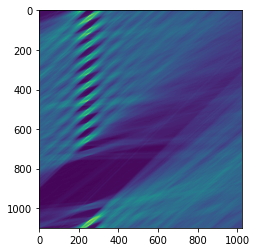

In [28]:
plt.imshow(fht1)

Для нахождения нужного угла поворота можно сделать преобразование Хаффа от повернутой на pi радиан картинки. Научимся восстанавливать координаты картинки, если мы уже знаем нужный угол поворота. 

In [31]:
def reverse_rotate_pos(x: int, y: int, w: int, h: int, cos_a: float, sin_a: float) -> tp.Tuple[float, float]:
    """ 
    Finds approximate position of point (x, y) on image with
    shape (w, h) that was rotated on angle `a` given
    by its cos and sin.

    Parameters:
    ----------
    x: int
    y: int
    w: int
    h: int
    cos_a: float
    sin_a: float
    
    Returns:
    -------
    x: float
        Approximate pos on horizontal axis.
    y: float
        Approximate pos on vertical axis.
    
    """
    # img = res * beta
    res_h = h * np.abs(cos_a) + w * np.abs(sin_a)
    res_w = w * np.abs(cos_a) + h * np.abs(sin_a)
    beta = min(h / res_h, w / res_w)
    
    # reverse resize and shift (because of rotate)
    x, y = x * beta - w * 0.5 * beta, y * beta - h * 0.5 * beta
    # reverse rotate
    x, y = x * cos_a + y * sin_a, -x * sin_a + y * cos_a    
    x, y = x + w * 0.5, y + h * 0.5
    return x, y


Теперь мы потенциально можем повернуть картинку на нужный угол, если будем знать нужный угол. Напишем функцию, чтобы протаскивать отдельные пиксели. Для начала напишем функцию через два цикла --- это будет потенциальное место для оптимизации. На питоне можно векторизовать функцию через jax (например, по параметру x и y) и применить ее сразу к сетке индексов --- это даст ощутимый прирост. Хорошо, что нужно ускорять только преобразование Хафа :)

In [60]:
def rotate_nearest_neighbour(img: np.ndarray, 
                             cos_a: float, sin_a: float) -> np.ndarray:
    """
    Rotate image on angle 'a', given by its cos and sin.
    Use nearest_neighbour strategy for interpolation.
    
    Parameters:
    ----------
    img: Image | np.ndarray
        PIL Image or np.ndarray to rotate
    cos_a: float
        cos of angle a
    sin_a: float
        sin of angle a
    
    Returns:
    res: np.ndarray
        Rotated image
    -------
    
    """
    img = np.array(img, dtype=np.float32)
    res = np.zeros_like(img, dtype=np.float32)
    H,W,_ = img.shape
    for i in range(W):
        for j in range(H):
            x_prev, y_prev = reverse_rotate_pos(i, j, W, H, cos_a, sin_a)
            x_prev = np.clip(int(np.round(x_prev)), 0, W - 1)
            y_prev = np.clip(int(np.round(y_prev)), 0, H - 1)
            res[j, i, :] = img[y_prev, x_prev, :]
    return cv2.convertScaleAbs(res)



In [70]:
def rotate_bilinear(img: np.ndarray, 
                    cos_a: float, sin_a: float) -> np.ndarray:
    """
    Rotate image on angle 'a', given by its cos and sin.
    Use bilinear strategy for interpolation.
    
    Parameters:
    ----------
    img: Image | np.ndarray
        PIL Image or np.ndarray to rotate
    cos_a: float
        cos of angle a
    sin_a: float
        sin of angle a
    
    Returns:
    res: np.ndarray
        Rotated image
    -------
    
    """
    img = np.array(img, dtype=np.float32)
    res = np.zeros_like(img, dtype=np.float32)
    H,W,_ = img.shape
    for i in range(W):
        for j in range(H):
            x_prev, y_prev = reverse_rotate_pos(i, j, W, H, cos_a, sin_a)
            
            # now we need to find 4 closest pixels for bilinear interpol
            x_l = x_prev - int(np.ceil(x_prev) == int(x_prev))
            x_r = x_l + 1
            y_t = y_prev - int(np.ceil(y_prev) == int(y_prev))
            y_b = y_t + 1
            # ensure not leaving image borders
            x_l, x_r = int(np.clip(x_l, 0, W - 1)), int(np.clip(x_r, 0, W - 1))
            y_t, y_b = int(np.clip(y_t, 0, H - 1)), int(np.clip(y_b, 0, H - 1))
            
            ax11 = img[y_t, x_l, :]
            ax21 = img[y_b, x_l, :]
            ax12 = img[y_t, x_r, :]
            ax22 = img[y_b, x_r, :]
            
            # bilinear intepolation (hope no errors)
            a_first = ax11 + (x_prev - x_l) * (ax12 - ax11)
            a_second = ax21 + (x_prev - x_l) * (ax22 - ax21)
            
            res[j, i, :] = np.clip(a_first + (y_prev - y_t) * (a_second - a_first), 
                                   0, 255)

    return cv2.convertScaleAbs(res)

In [71]:
def rotate(img: np.ndarray, cos_a: float, sin_a: float, 
           interpolation_type: str = "nearest_neighbour") -> np.ndarray:
    """
    Rotate image on angle 'a', given by its cos and sin.
    Use `interpolation_type` strategy for interpolation.
    
    Parameters:
    ----------
    img: Image | np.ndarray
        PIL Image or np.ndarray to rotate
    cos_a: float
        cos of angle a
    sin_a: float
        sin of angle a
    strategy: str
        strategy to use for intepolation ("nearest_neighbour" or
        "bilinear"). Default: "nearest_neighbour".
    
    Returns:
    res: np.ndarray
        Rotated image
    -------
    """
    
    if interpolation_type == "nearest_neighbour":
        return rotate_nearest_neighbour(img, cos_a, sin_a)
    elif interpolation_type == "bilinear":
        return rotate_bilinear(img, cos_a, sin_a)
    else:
        raise ValueError("Unsupported intepolation_type yet!")
        

Теперь осталось только находить необходимый для поворота угол, пользуясь точками с максимальной дисперсией полученного преобразования Хафа.

In [55]:
def argmax_var(arr: np.ndarray, axis: int=0):
    """
    Find index where variance of `arr` elements
    across `axis` is maximum.
    
    Parameters:
    ----------
    arr: np.ndarray
        Input array.
    axis: int, optional
        Axis along which to take variance.
        
    Returns:
    -------
    amax: 
        index of maximum variance across axis
    var[amax]:
        value of maximum variance across axis
    """
    var = np.var(arr, axis=0)
    amax = np.argmax(var)
    return amax, var[amax]


def find_angle(fht, fht_f):
    """
    Find angle (via sin and cos) image given by
    its FHT and FHT of flipped image should be
    rotated to achieve normal orientation.
    
    Parameters:
    ----------
    fht: np.ndarray
        FHT of input image
    fht_f: np.ndarray
        FHT of the same image, but flipped
    
    Returns:
    cos_a: float
        cos of angle to rotate
    sin_a: float
        sin of angle to rotate
    """
    assert fht.shape == fht_f.shape
    _, W = fht.shape
    
    ind, var = argmax_var(fht)
    ind_f, var_f = argmax_var(fht_f)
    if var > var_f:
        rho = np.sqrt(ind ** 2 + W ** 2)
        cos_a, sin_a = W / rho, ind / rho
        return cos_a, -sin_a
    else:
        rho = np.sqrt(ind_f ** 2 + W ** 2)
        cos_a, sin_a = W / rho, ind_f / rho
        return cos_a, sin_a

Теперь точно можно научиться поворачивать картинки обратно --- угол итогового поворота изображения получаем из логики, что направлении "правильная ориентация" будет иметь большую дисперсию в полученном преобразовании Хафа.

In [50]:
fht1_f = make_fht(get_image("1.jpg"), flip=True)

In [61]:
cos_a1, sin_a1 = find_angle(fht1, fht1_f)
normal1 = rotate(np.array(get_image("1.jpg"),dtype=np.float32), 
                         cos_a1, sin_a1)


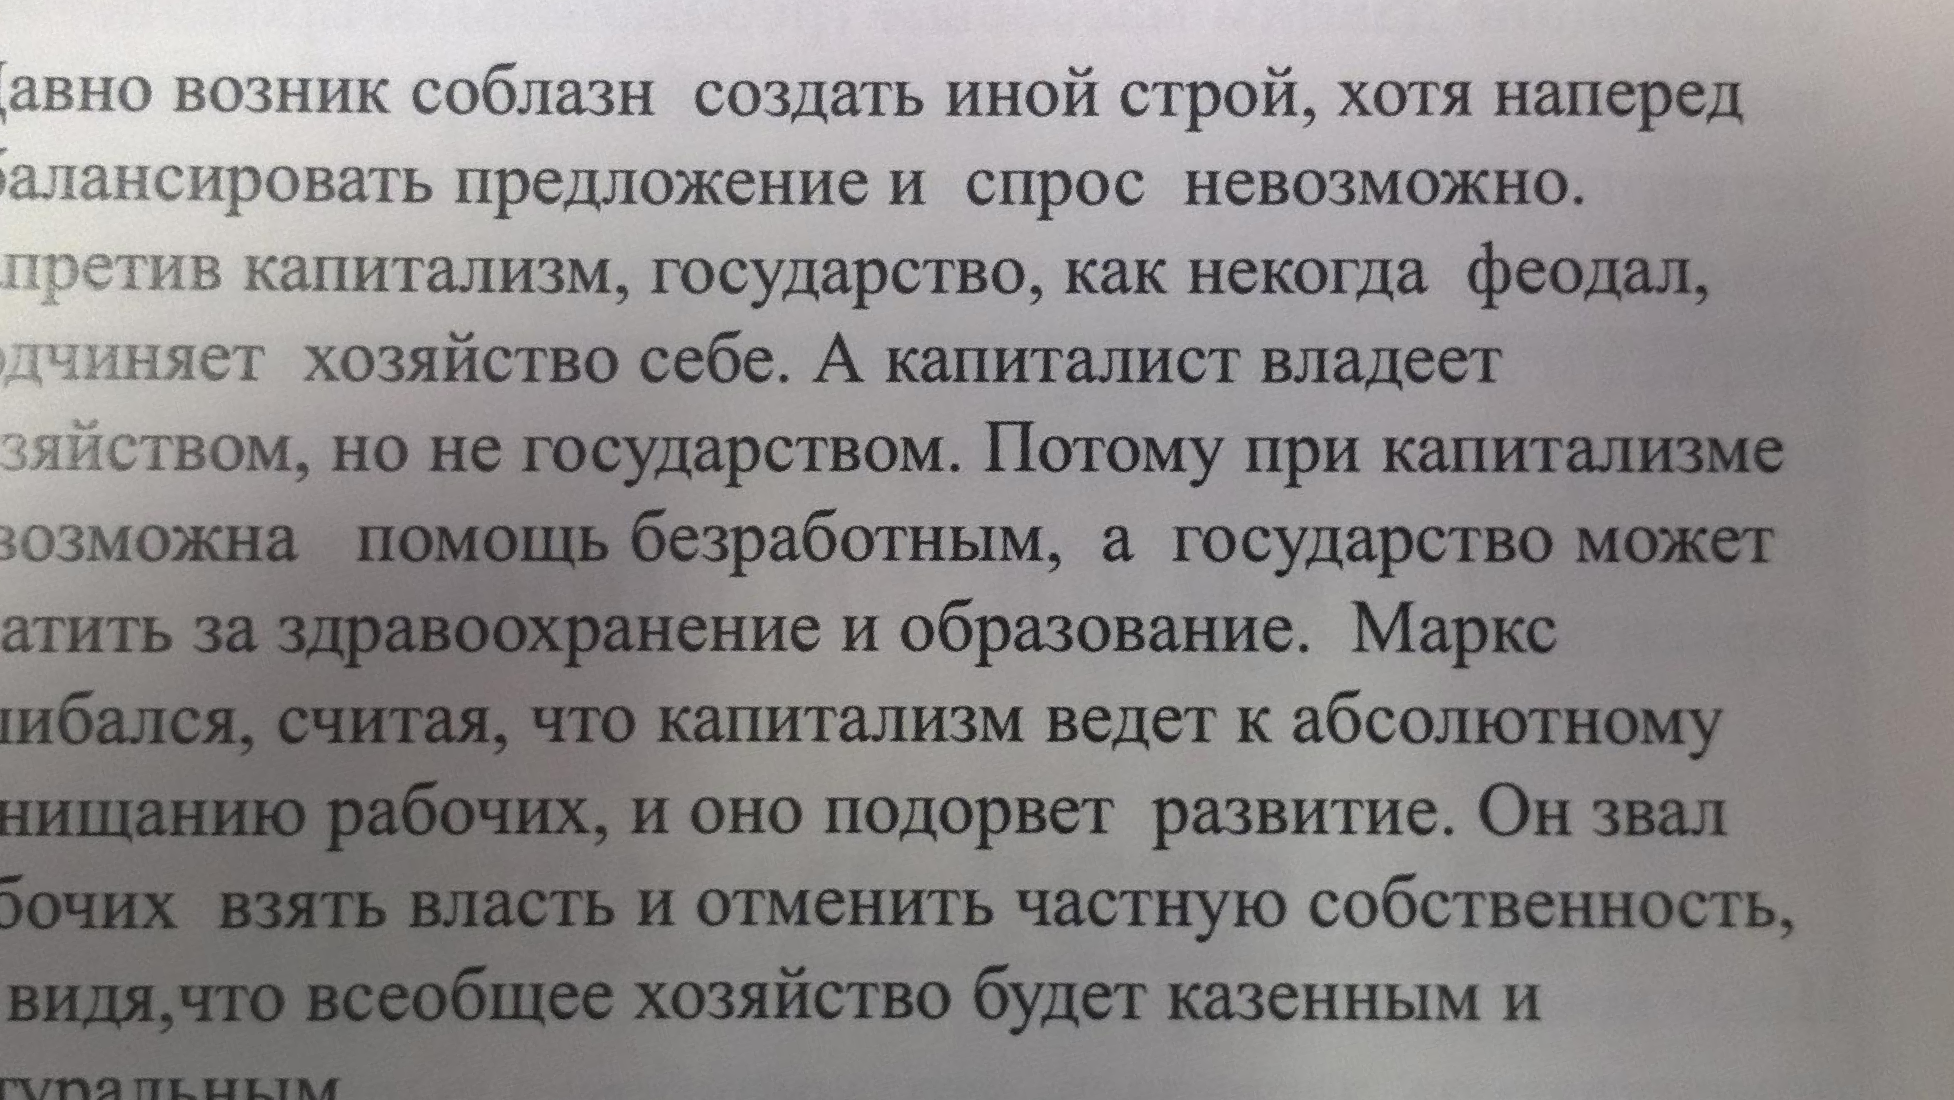

In [63]:
Image.fromarray(normal1)

In [75]:
def reverse_rotate(img: Image, interpolation_type: str = "nearest_neighbour"):
    """
    Given an image that was rotated, tries to rotate it back.
    """
    fht = make_fht(img)
    fht_f = make_fht(img, flip=True)
    cos_a, sin_a = find_angle(fht, fht_f)
    res = rotate(img, cos_a, sin_a, interpolation_type)
    return res

In [73]:
bilinear1 = reverse_rotate(get_image("1.jpg"), "bilinear")

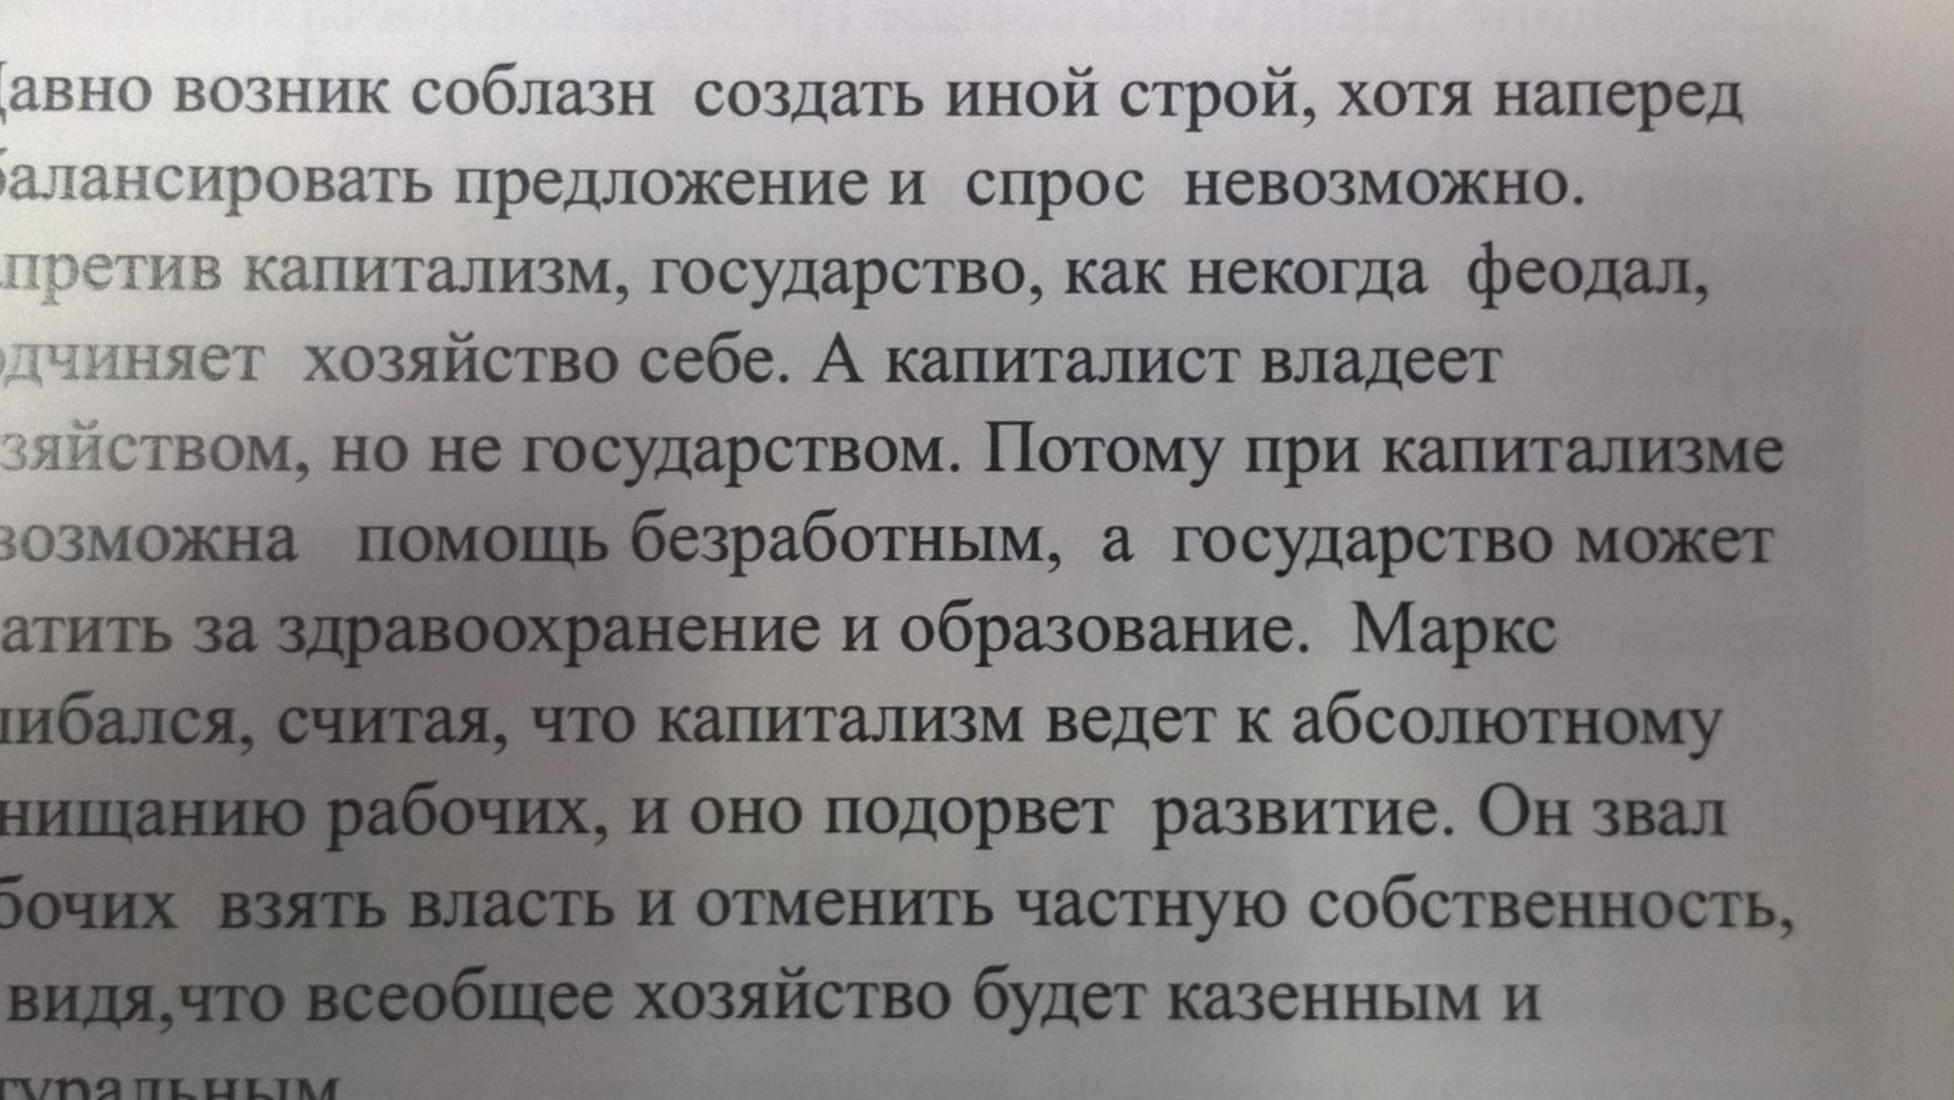

In [74]:
Image.fromarray(bilinear1)

Построим график времени работы преобразования Хафа от размера полоски в изображении. 

In [78]:
import time
from tqdm.auto import tqdm

img_1_g = preprocess(get_image("1.jpg"))
widths = [2 ** i for i in range(10)]

times = []
for w in tqdm(widths):
    start = time.time()
    fht_strip(img_1_g, 0, w)
    times.append(time.time() - start)
    
times = np.array(times)
sizes = np.array([w * img_1_g.shape[0] for w in widths], dtype=np.float64)
sizes /= (2 ** 20)

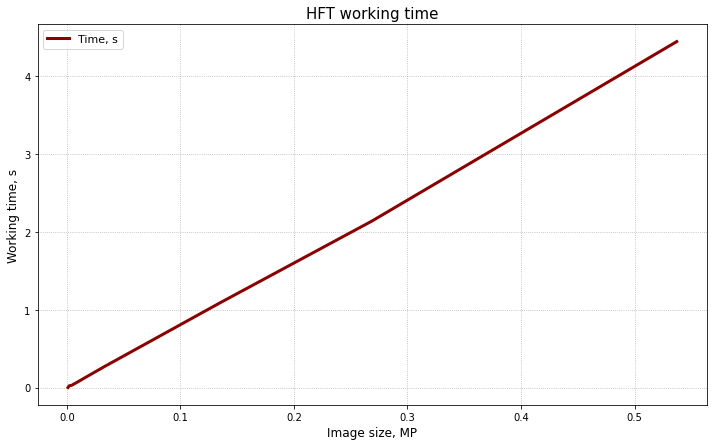

In [81]:
plt.figure(figsize=(12, 7))
plt.xlabel('Image size, MP', fontsize=12)
plt.ylabel('Working time, s', fontsize=12)
plt.title('HFT working time', fontsize=15)
plt.plot(sizes, times, label='Time, s', linewidth=3, color='darkred')
plt.legend(fontsize=11)
plt.grid(ls=":")
plt.show()

Как можно заметить, график имеет вполне линейный наклон, что неплохо ложится в гипотезу, что быстрое преобразование Хафа работает за $O(N^2 \log N)$ в силу своих рекурсивной реализации и вынужденности обрабатывать всю картинку целиком на каждом из $O(\log N)$ шагов. Потребление памяти тоже получается порядка $\Theta(N^2 \log N)$, так как мы создаем новые массивы на хранение всех промежуточных аккумуляторов --- алгоритм получился не inplace.

Потенциально можно соптимизировать использование памяти через написание inplace алгоритма, а пропускную способность можно сильно улучшить за счет векторизации еще одного цикла через индексацию numpy и использование jit для векторизации моих поточечных функций - это вполне возможно.

Метод интерполяции значительно не повлиял на качество картинки (глазом оценивал), но bilinear выглядит немного лучше.

Подсчет FHT также неплохо параллелится на несколько ядер - можем попробовать сделать это, но у нас уже кончается время (добавлю после дедлайна, если останется время).